In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os


In [3]:

train_data_dir="./veri seti/train/"
validation_data_dir="./veri seti/test/"


In [4]:
train_verisi = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,##Rastgele dönüşler için derece aralığı
					shear_range=0.3,##Kayma Şiddeti (Saat yönünün tersine derece cinsinden kesme açısı)
					zoom_range=0.3, ##Rastgele yakınlaştırma aralığı
					horizontal_flip=True, ##Boolean girişleri yatay olarak rastgele çevirir
					fill_mode='nearest') ##Girdi sınırları dışındaki noktalar, verilen moda göre doldurulur. 'nearest'

validation_verisi = ImageDataGenerator(rescale=1./255)

In [5]:
train_olusturucu = train_verisi.flow_from_directory( ##Bir dizine giden yolu alır ve arttırılmış veri yığınları oluşturur.
					train_data_dir,
					color_mode='grayscale', ##gri tonlama
					target_size=(48, 48), ##Bulunan tüm resimlerin boyutları yeniden ayarlanır
					batch_size=32, ##Veri gruplarının boyutu
					class_mode='categorical', ##Döndürülen etiket dizilerinin türünü belirler:
					shuffle=True) ##Verilerin karıştırılıp karıştırılmayacağı

validation_olusturucu = validation_verisi.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(48, 48),
							batch_size=32,
							class_mode='categorical',
							shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
duygu_etiketi=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_olusturucu.__next__()

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax')) ##7 çıktıya göre son katman softmax


print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [8]:
train_path = "./veri seti/train/"
test_path = "./veri seti/test"

In [9]:
train_foto_sayisi = 0
for root, dirs, files in os.walk(train_path):
    train_foto_sayisi += len(files)
    
test_foto_sayisi = 0
for root, dirs, files in os.walk(test_path):
    test_foto_sayisi += len(files)

print(train_foto_sayisi)
print(test_foto_sayisi)


28709
7178


In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

kayitnoktasi = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')## Eğitim sırasında en iyi model kaydedilir

erken_durdurma = EarlyStopping(monitor='val_loss', ##modelin eğitimi sırasında model eğitimi yavaşladığında erken durdurma uygulanır
                          min_delta=0,
                          patience=4, 
                          verbose=1,
                          restore_best_weights=True
                          )

ogrenme_orani_azalt = ReduceLROnPlateau(monitor='val_loss',## öğrenme oranı azalmakta ve minimum noktaya daha fazla yaklaşmakta.
                              factor=0.2,
                              patience=4,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [erken_durdurma,kayitnoktasi,ogrenme_orani_azalt]

model.compile(loss='categorical_crossentropy',## "Adam" algoritmasını uygulayan optimize edici.
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])



In [11]:
adim_sayisi = 25 ##erken durdurma olmaksızın modelin kaç kere eğitileceği (epoch)

history=model.fit(train_olusturucu,
                steps_per_epoch=train_foto_sayisi//32,
                epochs=adim_sayisi,
                validation_data=validation_olusturucu,
                validation_steps=test_foto_sayisi//32,
                callbacks=callbacks_list)


Epoch 1/25
897/897 [==============================] - 425s 473ms/step - loss: 1.7735 - accuracy: 0.2639 - val_loss: 1.6996 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 2/25
897/897 [==============================] - 171s 191ms/step - loss: 1.6659 - accuracy: 0.3356 - val_loss: 1.4934 - val_accuracy: 0.4153 - lr: 0.0010
Epoch 3/25
897/897 [==============================] - 167s 186ms/step - loss: 1.5377 - accuracy: 0.4016 - val_loss: 1.4011 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 4/25
897/897 [==============================] - 185s 206ms/step - loss: 1.4561 - accuracy: 0.4378 - val_loss: 1.3053 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 5/25
897/897 [==============================] - 189s 210ms/step - loss: 1.4037 - accuracy: 0.4590 - val_loss: 1.2916 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 6/25
897/897 [==============================] - 181s 201ms/step - loss: 1.3568 - accuracy: 0.4795 - val_loss: 1.2335 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 7/25
897/897 [==========================

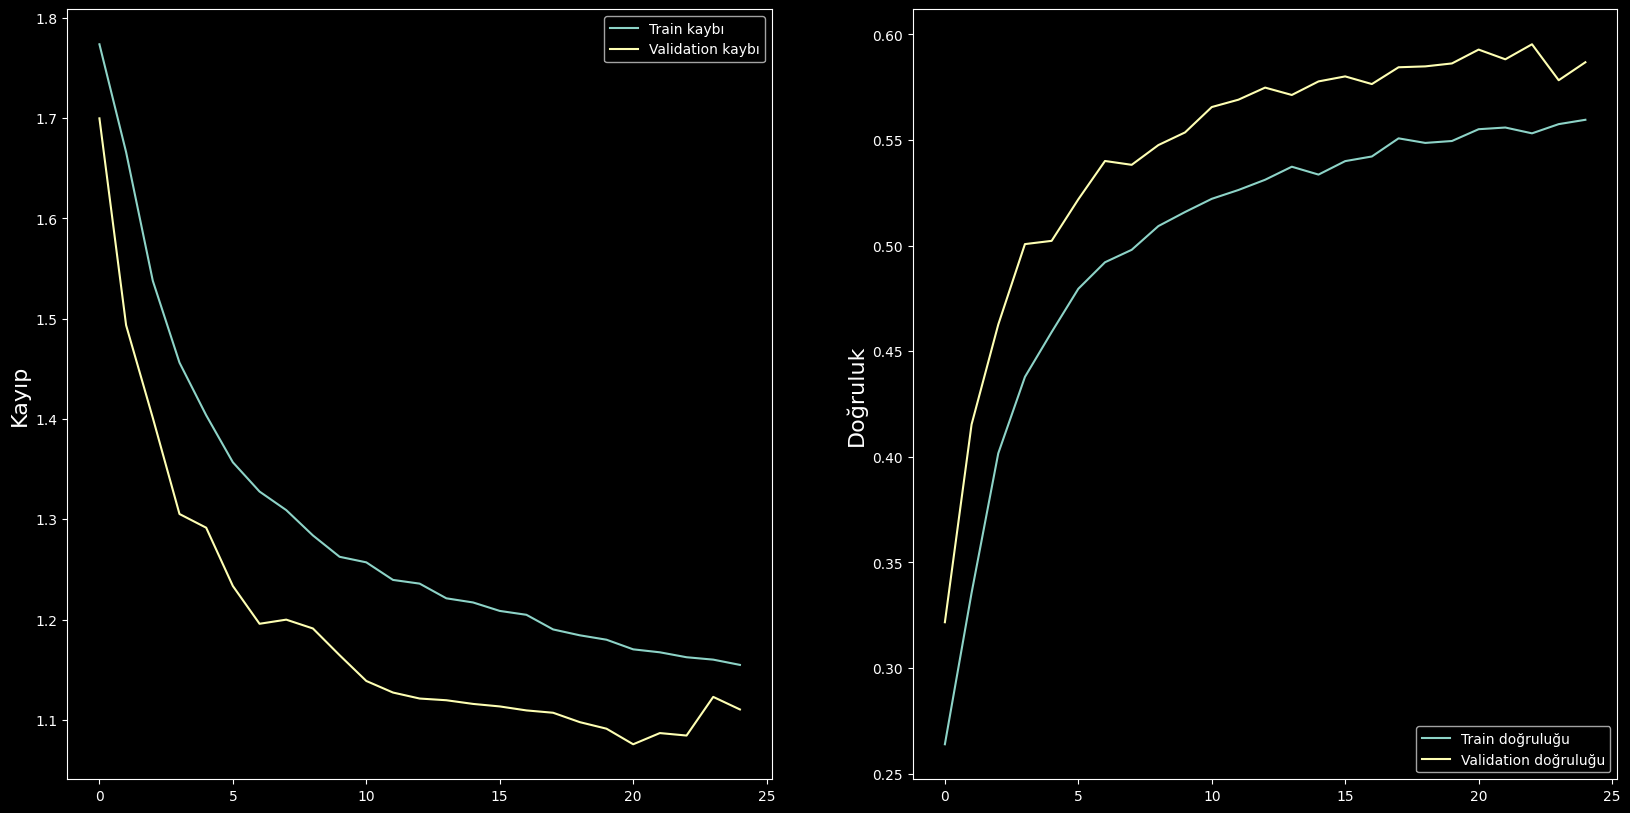

In [12]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.ylabel('Kayip', fontsize=16)
plt.plot(history.history['loss'], label='Train kaybı')
plt.plot(history.history['val_loss'], label='Validation kaybı')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Doğruluk', fontsize=16)
plt.plot(history.history['accuracy'], label='Train doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validation doğruluğu')
plt.legend(loc='lower right')
plt.show()

Eğitim sırasında, her bir eğitim döngüsü (epoch) sonunda model, doğrulama veri seti üzerindeki kaybı (loss) hesaplar. Bu kayba "validation loss" denir. İdeali, eğitim kaybının (training loss) ve doğrulama kaybının mümkün olduğunca yakın olmasıdır. Eğer eğitim kaybı düşerken doğrulama kaybı yükseliyorsa, model aşırı uyum (overfitting) yapmış olabilir ve genelleme performansı düşebilir.
**Burada 21. adımda eğitim kesilmiştir. çünkü eğitim kaydı düşüşteyken (traning los) doğrulama kaydı yükselişe (validation los) geçmiştir. Save best model burada algoritmayı durdurmuş Overfitingin önüne geçmiştir

In [13]:
model.save('model.h5')